In [39]:
# -*- coding: utf-8 -*-

import numpy as np

class GetValue():
    """
    calculate values from measured data without instance initialization.
    
    """
    
    @staticmethod
    def extract_Vth(VG:list, ID:list, target=1.0e-10) -> list:
        """Extract the Vth value from the measured data.

        Args:
            VG (list): Array of gate voltages.
            ID (list): Array of drain currents.
            target (float, optional): Target current value to find the threshold voltage. Defaults to 1.0e-10.
            
        Returns:
            Vth (list): Array of threshold voltages corresponding to each sweep in ID.
        """
        
        VG = np.array(VG)
        ID = np.array(ID)
        # n = len(np.unique(VG))  # if not used, can be removed
        sweepNum = ID.shape[1]
        vth_list = []

        for i in range(sweepNum):
            diff = ID[:, i] - target
            num = np.where(diff > 0)[0]

            if num.size == 0:
                vth = None
            else:
                # Find first consecutive pair
                k = None
                for a in range(len(num) - 1):
                    if num[a + 1] - num[a] == 1:
                        k = num[a]
                        break

                if k is None:
                    # if no consecutive pair is found, return None
                    vth = None
                elif k == 0:
                    # if the first point is the point of interest
                    vth = VG[k]
                else:
                    # calculate Vth by linear interpolation
                    x_vals = [ID[k - 1, i], ID[k, i]]
                    y_vals = [VG[k - 1], VG[k]]

                    # Ensure x_vals are in ascending order
                    if x_vals[0] > x_vals[1]:
                        x_vals, y_vals = x_vals[::-1], y_vals[::-1]  # reverse both lists
                    
                    # interpolate
                    vth = float(np.interp(target, x_vals, y_vals))

            vth_list.append(vth)

        return vth_list


    @staticmethod
    def extract_SS(VG:list, ID:list, target=1.0e-9) -> list:
        """Extract the subthreshold swing (SS) from the measured data.

        Args:
            VG (list): Array of gate voltages.
            ID (list): Array of drain currents.
            target (float, optional): Target current value to find the subthreshold swing. Defaults to 1.0e-9.

        Returns:
            ss (list): Array of subthreshold swings corresponding to each sweep in ID. 
            
        Note:
            ss = (V1 - Vth) * 1000, where V1(@ 1e-9), Vth(@ 1e-10) respectively.
        """

        VG = np.array(VG)
        ID = np.array(ID)
        sweepNum = ID.shape[1]
        vth_list = GetValue.extract_Vth(VG, ID)
        ss_list = []

        for i in range(sweepNum):
            diff = ID[:, i] - target

            # Find first consecutive pair where the sign changes
            k = None
            for idx in range(len(VG) - 1):
                if diff[idx] * diff[idx + 1] <= 0:
                    k = idx
                    break

            if k is None:  
                # if no sign change is found, return None
                ss_list.append(None)
                continue

            # Calculate V1 based on the index k
            if k == 0:
                V1 = VG[k]
            else:
                x_vals = [ID[k, i], ID[k + 1, i]]
                y_vals = [VG[k], VG[k + 1]]
                
                # Ensure x_vals are in ascending order
                if x_vals[0] > x_vals[1]:
                    x_vals, y_vals = x_vals[::-1], y_vals[::-1]
                
                V1 = float(np.interp(target, x_vals, y_vals))

            # ss calculation [mV/decade]
            vth = vth_list[i] if vth_list[i] is not None else np.nan
            ss = (V1 - vth) * 1000
            ss_list.append(ss)

        return ss_list
        


In [36]:
VG_list = [-2, -1.5, -1, -0.5, 0, 0.5, 1.0, 1.5, 2.0]
ID_list_2D = [
    [1e-12, 2e-12],
    [1e-11, 3e-11],
    [5e-11, 8e-11],
    [2e-10, 3e-10],
    [1e-9, 2e-9],
    [5e-9, 8e-9],
    [2e-8, 3e-8],
    [1e-7, 2e-7],
    [5e-7, 8e-7]
]


In [19]:
vth_results = extract_Vth(VG_list, ID_list_2D, target=1e-10)
print(vth_results)

[-0.8333333333333333, -0.9545454545454546]


In [37]:
vth = GetValue.extract_Vth(VG_list, ID_list_2D)
print(vth)

[-0.8333333333333333, -0.9545454545454546]


In [40]:
ss = GetValue.extract_SS(VG_list, ID_list_2D)
print(ss)

[833.3333333333333, 660.4278074866311]


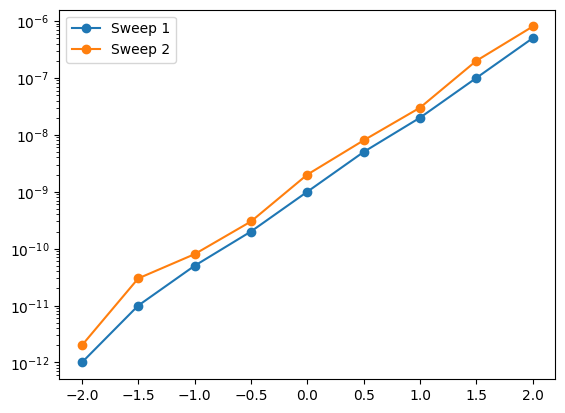

In [26]:
import matplotlib.pyplot as plt

VG = np.array(VG_list)
ID = np.array(ID_list_2D)

plt.plot(VG, ID[:,0], marker='o', label='Sweep 1')
plt.plot(VG, ID[:,1], marker='o', label='Sweep 2')
plt.yscale('log')
plt.legend()